#### Import libraries

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from matplotlib import pyplot as plt


#### Show installed GPUs.

In [2]:

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus :
    print("Name: ", gpu.name, " Type: ", gpu.device_type)


Name:  /physical_device:GPU:0  Type:  GPU


#### Load the dataset.

In [3]:

df = pd.read_csv('../dataset/preprocessed-sam-dataset.csv', sep='|',
                 dtype = {'CZ': 'float32', 'FZ': 'float32', 'Fp1': 'float32', 'F3': 'float32',
                          'FC1': 'float32', 'FC5': 'float32', 'FT9': 'float32', 'T7': 'float32',
                          'CP5': 'float32', 'P3': 'float32', 'P7': 'float32', 'PO9': 'float32',
                          'PZ': 'float32', 'O2': 'float32', 'P4': 'float32', 'CP6': 'float32',
                          'FT10': 'float32', 'FC6': 'float32', 'F8': 'float32', 'Fp2': 'float32',
                          'Scale': 'int8'})


#### Display the dataset size.

In [4]:
df.shape

(140800, 21)

#### Train a MLP model

- 5-layer architecture (100, 300, 500, 300 and 100 units).
- Data augmentation (5x).


In [5]:

act_fuction = "relu"
kernel_init = "lecun_uniform"
kernel_reg = L2(0.00000001)
bias_init = "zeros"

def create_baseline() :
    model = Sequential()
    model.add(Dense(100, input_shape = (20,), activation = act_fuction, kernel_initializer = kernel_init, 
                    kernel_regularizer = kernel_reg, bias_initializer = bias_init))
    model.add(BatchNormalization())
    model.add(Dense(300, activation = act_fuction, kernel_initializer = kernel_init, kernel_regularizer = kernel_reg,
                    bias_initializer = bias_init))
    model.add(BatchNormalization())
    model.add(Dense(500, activation = act_fuction, kernel_initializer = kernel_init, kernel_regularizer = kernel_reg,
                    bias_initializer = bias_init))
    model.add(BatchNormalization())
    model.add(Dense(300, activation = act_fuction, kernel_initializer = kernel_init, kernel_regularizer = kernel_reg,
                    bias_initializer = bias_init))
    model.add(BatchNormalization())
    model.add(Dense(100, activation = act_fuction, kernel_initializer = kernel_init, kernel_regularizer = kernel_reg,
                    bias_initializer = bias_init))
    model.add(BatchNormalization())
    model.add(Dense(11, activation = 'softmax'))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    return model


# Data augmentation.
print("\nStarting data augmentation.")
df_list = []
for count in range(0, 11) :
    df_list.append(df[df.iloc[:, 20] == count])
df_result = pd.DataFrame(columns = ['CZ', 'FZ', 'Fp1', 'F3', 'FC1', 'FC5', 'FT9', 'T7',
                          'CP5', 'P3', 'P7', 'PO9', 'PZ', 'O2', 'P4', 'CP6',
                          'FT10', 'FC6', 'F8', 'Fp2', 'Scale'])
for count in range(0, 11) :
    df_upsampled = resample(df_list[count], replace = True, n_samples = 61000,
                            stratify = df_list[count])
    df_result = pd.concat([df_result, df_upsampled])
print("Dataset shape: {}".format(df_result.shape))
print(df_result.Scale.value_counts())


# Split dataset (training and test sets) and scale data.
print("\nSplitting and scalling data")
X = df_result.drop('Scale', axis = 1)
y = df_result['Scale'].astype('int8') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)


# Train the MLP model and evaluate it.
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 200)
model = create_baseline()
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 1200, batch_size = 512, verbose = 1, callbacks = [es])

_, train_accuracy = model.evaluate(X_train, y_train, verbose = 0)
_, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)

print("\nTrain Accuracy: {:.4f}".format(train_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))
y_pred = np.argmax(model.predict(X_test), axis = 1)
print("\nShow metrics:")
print(classification_report(y_test, y_pred, zero_division = 0))



Starting data augmentation.
Dataset shape: (671000, 21)
0     61000
1     61000
2     61000
3     61000
4     61000
5     61000
6     61000
7     61000
8     61000
9     61000
10    61000
Name: Scale, dtype: int64

Splitting and scalling data
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 300)               30300     
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
          

Epoch 96/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.2559 - accuracy: 0.9121 - val_loss: 0.2341 - val_accuracy: 0.9412
Epoch 97/1200
944/944 [==============================] - 20s 21ms/step - loss: 0.2571 - accuracy: 0.9120 - val_loss: 0.2398 - val_accuracy: 0.9412
Epoch 98/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.2533 - accuracy: 0.9134 - val_loss: 0.2291 - val_accuracy: 0.9449
Epoch 99/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.2542 - accuracy: 0.9129 - val_loss: 0.2300 - val_accuracy: 0.9438
Epoch 100/1200
944/944 [==============================] - 18s 20ms/step - loss: 0.2510 - accuracy: 0.9141 - val_loss: 0.2302 - val_accuracy: 0.9443
Epoch 101/1200
944/944 [==============================] - 21s 22ms/step - loss: 0.2490 - accuracy: 0.9147 - val_loss: 0.2331 - val_accuracy: 0.9436
Epoch 102/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.2482 - accuracy: 0.9149 - val_loss

944/944 [==============================] - 19s 20ms/step - loss: 0.1651 - accuracy: 0.9434 - val_loss: 0.1368 - val_accuracy: 0.9776
Epoch 207/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.1649 - accuracy: 0.9440 - val_loss: 0.1390 - val_accuracy: 0.9769
Epoch 208/1200
944/944 [==============================] - 20s 21ms/step - loss: 0.1627 - accuracy: 0.9446 - val_loss: 0.1451 - val_accuracy: 0.9748
Epoch 209/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1634 - accuracy: 0.9445 - val_loss: 0.1414 - val_accuracy: 0.9761
Epoch 210/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1601 - accuracy: 0.9455 - val_loss: 0.1410 - val_accuracy: 0.9765
Epoch 211/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1644 - accuracy: 0.9438 - val_loss: 0.1379 - val_accuracy: 0.9770
Epoch 212/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.1637 - accuracy: 0.9445 - val_loss: 0.1430 - 

944/944 [==============================] - 21s 22ms/step - loss: 0.1291 - accuracy: 0.9560 - val_loss: 0.1141 - val_accuracy: 0.9857
Epoch 317/1200
944/944 [==============================] - 20s 21ms/step - loss: 0.1283 - accuracy: 0.9563 - val_loss: 0.1193 - val_accuracy: 0.9843
Epoch 318/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.1298 - accuracy: 0.9564 - val_loss: 0.1176 - val_accuracy: 0.9845
Epoch 319/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1290 - accuracy: 0.9563 - val_loss: 0.1191 - val_accuracy: 0.9854
Epoch 320/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.1284 - accuracy: 0.9563 - val_loss: 0.1192 - val_accuracy: 0.9838
Epoch 321/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1301 - accuracy: 0.9560 - val_loss: 0.1207 - val_accuracy: 0.9841
Epoch 322/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.1286 - accuracy: 0.9562 - val_loss: 0.1175 - 

944/944 [==============================] - 18s 19ms/step - loss: 0.1106 - accuracy: 0.9627 - val_loss: 0.1147 - val_accuracy: 0.9873
Epoch 427/1200
944/944 [==============================] - 18s 20ms/step - loss: 0.1097 - accuracy: 0.9628 - val_loss: 0.1149 - val_accuracy: 0.9871
Epoch 428/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1119 - accuracy: 0.9623 - val_loss: 0.1126 - val_accuracy: 0.9883
Epoch 429/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1103 - accuracy: 0.9628 - val_loss: 0.1132 - val_accuracy: 0.9878
Epoch 430/1200
944/944 [==============================] - 19s 21ms/step - loss: 0.1109 - accuracy: 0.9625 - val_loss: 0.1134 - val_accuracy: 0.9875
Epoch 431/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.1116 - accuracy: 0.9621 - val_loss: 0.1115 - val_accuracy: 0.9886
Epoch 432/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.1078 - accuracy: 0.9636 - val_loss: 0.1130 - 

944/944 [==============================] - 36s 38ms/step - loss: 0.0988 - accuracy: 0.9669 - val_loss: 0.1139 - val_accuracy: 0.9890
Epoch 537/1200
944/944 [==============================] - 35s 37ms/step - loss: 0.0992 - accuracy: 0.9666 - val_loss: 0.1098 - val_accuracy: 0.9894
Epoch 538/1200
944/944 [==============================] - 26s 28ms/step - loss: 0.1006 - accuracy: 0.9663 - val_loss: 0.1138 - val_accuracy: 0.9891
Epoch 539/1200
944/944 [==============================] - 27s 29ms/step - loss: 0.0991 - accuracy: 0.9666 - val_loss: 0.1102 - val_accuracy: 0.9893
Epoch 540/1200
944/944 [==============================] - 28s 30ms/step - loss: 0.0983 - accuracy: 0.9671 - val_loss: 0.1101 - val_accuracy: 0.9893
Epoch 541/1200
944/944 [==============================] - 27s 28ms/step - loss: 0.0998 - accuracy: 0.9664 - val_loss: 0.1115 - val_accuracy: 0.9894
Epoch 542/1200
944/944 [==============================] - 35s 37ms/step - loss: 0.0992 - accuracy: 0.9667 - val_loss: 0.1092 - 

944/944 [==============================] - 19s 20ms/step - loss: 0.0899 - accuracy: 0.9699 - val_loss: 0.1116 - val_accuracy: 0.9903
Epoch 647/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.0905 - accuracy: 0.9700 - val_loss: 0.1099 - val_accuracy: 0.9906
Epoch 648/1200
944/944 [==============================] - 18s 20ms/step - loss: 0.0900 - accuracy: 0.9698 - val_loss: 0.1106 - val_accuracy: 0.9906
Epoch 649/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.0909 - accuracy: 0.9700 - val_loss: 0.1077 - val_accuracy: 0.9907
Epoch 650/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.0897 - accuracy: 0.9703 - val_loss: 0.1085 - val_accuracy: 0.9911
Epoch 651/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.0887 - accuracy: 0.9705 - val_loss: 0.1118 - val_accuracy: 0.9900
Epoch 652/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.0896 - accuracy: 0.9704 - val_loss: 0.1133 - 

944/944 [==============================] - 18s 19ms/step - loss: 0.0821 - accuracy: 0.9729 - val_loss: 0.1118 - val_accuracy: 0.9905
Epoch 757/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.0825 - accuracy: 0.9729 - val_loss: 0.1138 - val_accuracy: 0.9907
Epoch 758/1200
944/944 [==============================] - 18s 20ms/step - loss: 0.0823 - accuracy: 0.9729 - val_loss: 0.1119 - val_accuracy: 0.9906
Epoch 759/1200
944/944 [==============================] - 18s 20ms/step - loss: 0.0839 - accuracy: 0.9721 - val_loss: 0.1104 - val_accuracy: 0.9909
Epoch 760/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.0818 - accuracy: 0.9730 - val_loss: 0.1140 - val_accuracy: 0.9908
Epoch 761/1200
944/944 [==============================] - 19s 20ms/step - loss: 0.0838 - accuracy: 0.9725 - val_loss: 0.1135 - val_accuracy: 0.9906
Epoch 762/1200
944/944 [==============================] - 18s 19ms/step - loss: 0.0844 - accuracy: 0.9720 - val_loss: 0.1144 - 

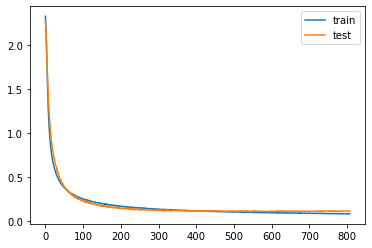

In [6]:

# Plot loss history
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()


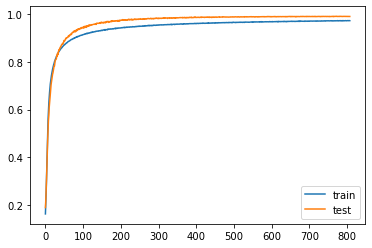

In [7]:

# Plot accuracy history
plt.plot(history.history["accuracy"], label = "train")
plt.plot(history.history["val_accuracy"], label = "test")
plt.legend()
plt.show()
